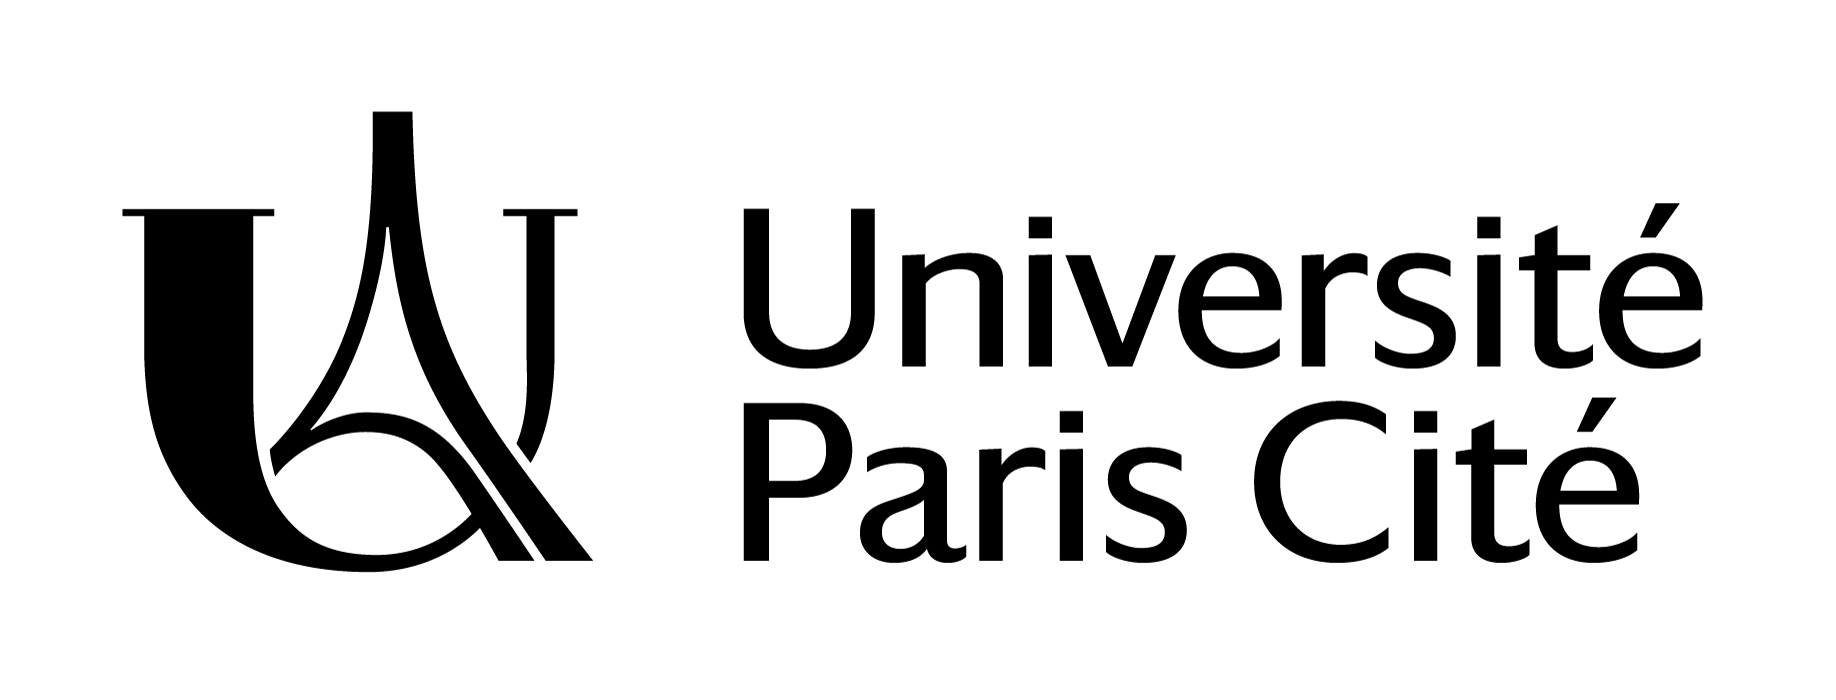
## M2 VMI - TP AD: Remote Sensing - Let's Make Paris Green Again

You can choose to do this lab on either a Google Colab instance, or locally. If you do it on a Colab instance, make sure to deactivate the GPU, you will not need it.

## 1) Loading the data
Let's get all of the data required for this lab. You can find the data [here](https://drive.proton.me/urls/2W5RBH29FM#QhjIe8wDCKm7).

Download the data, unzip the folder and fill the path in the variable below. If you want to do it on Colab, you can upload the data to your colab environment.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DL_Data/IMASatADTP.zip -d /content/

Archive:  /content/drive/MyDrive/DL_Data/IMASatADTP.zip
   creating: /content/IMASatADTP/
  inflating: /content/__MACOSX/._IMASatADTP  
   creating: /content/IMASatADTP/Sentinel2/
   creating: /content/IMASatADTP/Boundaries/
   creating: /content/IMASatADTP/Orthophotos/
  inflating: /content/__MACOSX/IMASatADTP/._Orthophotos  
   creating: /content/IMASatADTP/Sentinel2/S2_20230227/
  inflating: /content/__MACOSX/IMASatADTP/Sentinel2/._S2_20230227  
   creating: /content/IMASatADTP/Sentinel2/S2_20210227/
  inflating: /content/__MACOSX/IMASatADTP/Sentinel2/._S2_20210227  
   creating: /content/IMASatADTP/Sentinel2/S2_20200709/
  inflating: /content/__MACOSX/IMASatADTP/Sentinel2/._S2_20200709  
   creating: /content/IMASatADTP/Sentinel2/S2_20211221/
  inflating: /content/__MACOSX/IMASatADTP/Sentinel2/._S2_20211221  
   creating: /content/IMASatADTP/Sentinel2/S2_20190725/
  inflating: /content/__MACOSX/IMASatADTP/Sentinel2/._S2_20190725  
   creating: /content/IMASatADTP/Sentinel2/S2_20201

In [3]:
base_folder = '/content/IMASatADTP'

## 2) Have a look at the data
### 2.1) Sentinel 2 images
You have a series of folders with a name starting with "S2". These are Sentinel 2 images. In each folder, you have a series of 4 .tif files. Each represent one band of Sentinel-2. For the sake of simplicity, we only included bands that are relevant for this lab.
The different wavelenghts for the spectral bands can be foudn on the technical specifications of the satellite, or on [wikipedia](https://en.wikipedia.org/wiki/Sentinel-2).

Let's read an image. For this, we will use [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) which allows to easily read geospatial rasters.

In [4]:
from pathlib import Path

base_path = Path(base_folder)

In [5]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 78.9 MB/s eta 0:00:00


First, we will write a function read_S2_image that reads a list of bands, given as a list of strings.

In [25]:
import rasterio
import rasterio.mask

def read_S2_image(image_path, bands, window=None, mask=None):
    """Reads individual bands and returns them as a dictionnary

    Parameters
    ----------
    image_path : str
        A string indicating the path and filename (without '{band}.tif') of the image to be loaded
    bands : list
        A list of strings indicating the bands to be loaded (e.g. ['B2, 'B3']
    window : rasterio.Window.window optional
        A window to only read part of the raster
    mask : fiona shape geometry optional
        A fiona shape geometry to be used to mask and crop the image

    Returns
    -------
    dict
        a dictionnary in which the keys are the names of the bands (e.g. 'B2') and the values are the
        image data of the band.
    """
    individual_bands = {}
    for band in bands:
        with rasterio.open(image_path + band + ".tif") as band_src:
            if not mask:
                individual_bands[band] = band_src.read(1, window=window).astype('float32')
            if mask:
                individual_bands[band] = rasterio.mask.mask(band_src, mask, crop=True)[0][0]

    return individual_bands

Then, we create a function show_imageRGB that will print 3 bands from the loaded bands as an RGB image.

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def show_imageRGB(individual_bands, bands_to_print, display_box=None, method=None, val_min=100, val_max=2500, min_perc=2, max_perc=98):
    """Print an RGB image from individual bands, with optional normalization.

    Parameters
    ----------
    individual_bands : dict
        A dictionnary of the loaded bands.
    bands_to_print: list
        A list of string, containing the bands' names to print (e.g. 'B2') in the RGB order.
    display_box : tuple, optional
        A 4-dimension tuple indicating the starting column, ending column, starting row and ending row to print.
        If not given, will print the whole image
    method: string, optional
        A string giving the method used to compute the minimum and maximum value to print.
        If method is None, the raw data will be printed (i.e. no stretch and clip)
        If mehtod is 'user_defined', the minimum and maximum values will be parameters val_min and val_max
        If method is 'percentiles', the minimum and maximum value will be computed as the min_perc and max_perc percentiles.
    val_min: integer, optional
        Used if method is 'user_defined' as the minimum value for all bands.
    val_max: integer, optional
        Used if method is 'user_defined' as the maximum value for all bands.
    min_perc: float, optional
        Used if method is 'percentile' as the percentile to be used for the computation of the minimum value.
    max_perc: float, optional
        Used if method is 'percentile' as the percentile to be used for the computation of the maximum value.
    """

    if display_box:
        startx, endx, starty, endy = display_box
    else:
        startx, starty = 0, 0
        endy, endx = individual_bands[bands_to_print[0]].shape

    image = np.empty((endy-starty, endx-startx) + (3,))
    for channel, band in enumerate(bands_to_print):
        if method == "percentiles":
            title = f"Stretch and clip values from {min_perc} to {max_perc} percentiles"
            val_min, val_max = np.percentile(individual_bands[band], [min_perc, max_perc])
        elif method == "user-defined":
            title = f"Stretch and clip values from {val_min} to {val_max}"
        else:
            title = f"Raw data"
            val_min, val_max = 1, np.max(individual_bands[band]) #0 is nodata
        image[:, :, channel] = np.clip((individual_bands[band][starty:endy, startx:endx] - val_min) / (val_max - val_min), 0, 1)

    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.show()


**Question 1**
Using these two functions, print the RGB image of the image S2_20230604. Experiment with the 3 visualization methods.
- Which bands did you print, in which order?
- Which normalization method seems to give the most natural result?
- Which parameters did you use?

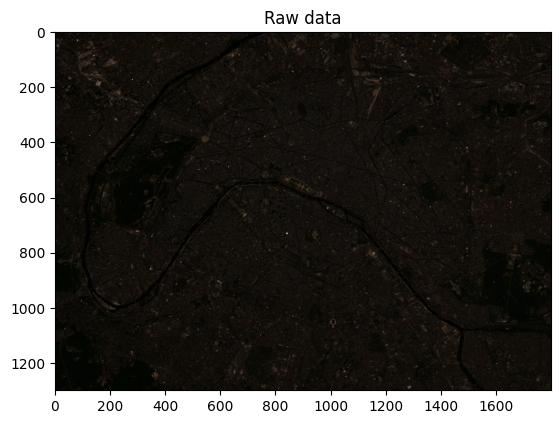

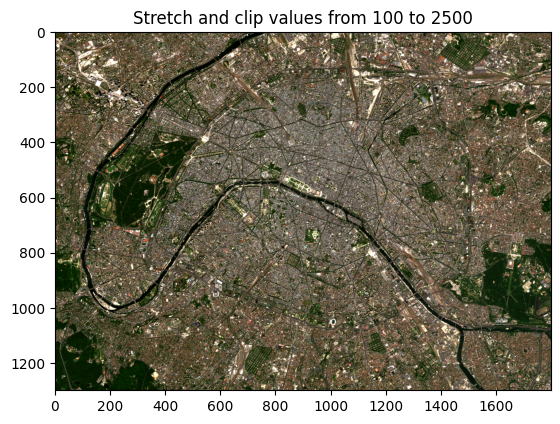

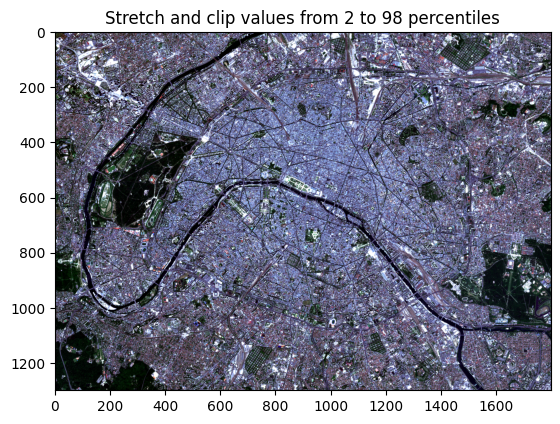

In [27]:
individual_bands = read_S2_image(str(base_path / "Sentinel2" / "S2_20230604" / "SENTINEL2A_20230604-105732-239_L2A_T31UDQ_C_V3-1_FRE_"), bands=["B2", "B3", "B4", "B8"])
display_box = (4200, 6000, 8200, 9500)
bands_to_print = ["B4", "B3", "B2"]
show_imageRGB(individual_bands, bands_to_print, display_box)
show_imageRGB(individual_bands, bands_to_print, display_box, method = "user-defined", val_min = 100, val_max = 2500)
show_imageRGB(individual_bands, bands_to_print, display_box, method = "percentiles", min_perc = 2, max_perc = 98)

### 2.2 Orthophotos

You have a folder that is filled with 13 orthophotos from Paris. Let's read one of them. Since each file is 25000x25000 pixels, we will only read part of the file. This can be done through a window.



In [28]:
from rasterio.windows import Window

filename = base_path / "Orthophotos" / "75-2018-0650-6865-LA93-0M20-E080.jp2"

win = Window(4000, 14500, 2000, 2000)

with rasterio.open(filename) as src:
    image = src.read(window=win)
image = image.transpose(1, 2, 0)

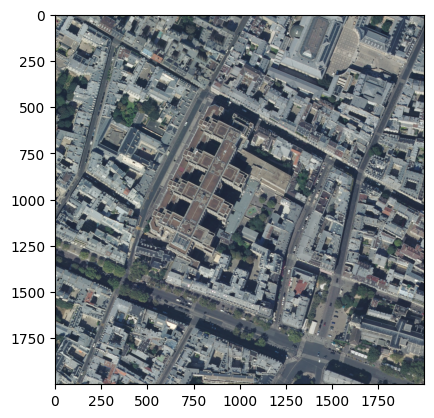

In [10]:
plt.imshow(image)

**Question 2**
Zoom on the orthophoto and the Sentinel-2 images (at the same location).

- What type of information can you see on the orthophoto, that is not available on the Sentinel-2 data?
- Why would someone work with Sentinel-2 data instead of orthophotos?

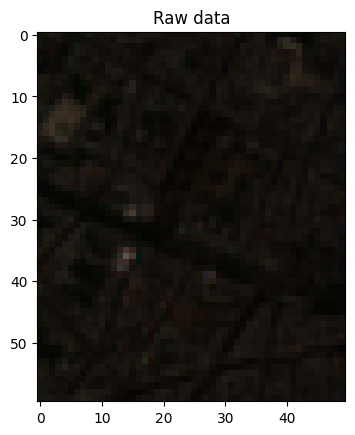

In [36]:
display_box = (5075, 5125, 8820, 8880)
show_imageRGB(individual_bands, bands_to_print, display_box)

## 3) How green is Paris?

We will now dive into the main topic of this lab. Our goal is to see how the vegetation in Paris evolves over the years, with Sentinel-2 data.

### 3.1) Loading the data
Let's load a time series of Sentinel 2 images. However, this time, we only want to know what happens in Paris, and not the departments that share a border with Paris. To achieve that, we are going to mask the image (we still need to have a rectangular image). We are going to load a shapefile that contains the boundaries, as vectors, of the different departments of Ile de France. We use [Fiona](https://fiona.readthedocs.io/en/latest/manual.html) for that.

In [12]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 101.1 MB/s eta 0:00:00


After loading the vectors, we need to find which one corresponds to Paris. For that, you can look at the properties dictionnary in each shape. Find the index, and fill it below.

In [13]:
import fiona
import rasterio.mask

with fiona.open(base_path / "Boundaries" / "iDfBoundaries.shp", "r") as shapefile:
    shapes = [feature for feature in shapefile]

for index, shape in enumerate(shapes):
    print(f"Looking at shape {index}")
    for k,v in shape.properties.items():
        print(k, v)

index = 5
shape = shapes[index]["geometry"]


Looking at shape 0
code_insee 94D
code_ins_1 11
nom_offici Val-de-Marne
date_creat 2018/11/24 00:00:00.000
date_modif 2022/02/14 12:33:02.296
date_d_app None
date_de_co None
liens_vers SURFACTI0000000004266254
code_siren None
Looking at shape 1
code_insee 92D
code_ins_1 11
nom_offici Hauts-de-Seine
date_creat 2018/11/24 00:00:00.000
date_modif 2022/04/13 15:09:35.250
date_d_app None
date_de_co None
liens_vers SURFACTI0000000000391412
code_siren None
Looking at shape 2
code_insee 95D
code_ins_1 11
nom_offici Val-d'Oise
date_creat 2018/11/24 00:00:00.000
date_modif 2022/12/07 11:20:49.307
date_d_app None
date_de_co None
liens_vers SURFACTI0000000003754646
code_siren None
Looking at shape 3
code_insee 93D
code_ins_1 11
nom_offici Seine-Saint-Denis
date_creat 2018/11/24 00:00:00.000
date_modif 2022/12/07 11:20:49.307
date_d_app None
date_de_co None
liens_vers SURFACTI0000000002556857
code_siren None
Looking at shape 4
code_insee 78D
code_ins_1 11
nom_offici Yvelines
date_creat 2018/11/24 0

Finally, we can load our series of images. Load them, and print the first one to check that the mask have been correctly applied. Everything outside of Paris should have the value 0, indicating *nodata*.

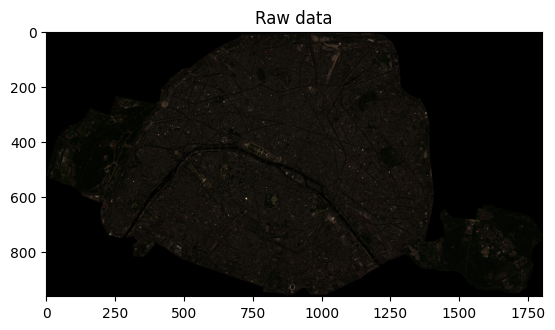

In [14]:
filenames = [str(base_path / "Sentinel2" / "S2_20190725" / "SENTINEL2A_20190725-105733-375_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20200106" / "SENTINEL2B_20200106-105723-246_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20200530" / "SENTINEL2A_20200530-105734-586_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20200709" / "SENTINEL2A_20200709-105732-481_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20201126" / "SENTINEL2A_20201126-105729-415_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20210227" / "SENTINEL2A_20210227-110724-513_L2A_T31UDQ_C_V2-2_FRE_"),
             str(base_path / "Sentinel2" / "S2_20210614" / "SENTINEL2A_20210614-105728-822_L2A_T31UDQ_C_V3-0_FRE_"),
             str(base_path / "Sentinel2" / "S2_20211221" / "SENTINEL2A_20211221-105729-409_L2A_T31UDQ_C_V3-0_FRE_"),
             str(base_path / "Sentinel2" / "S2_20220212" / "SENTINEL2A_20220212-110724-196_L2A_T31UDQ_C_V3-0_FRE_"),
             str(base_path / "Sentinel2" / "S2_20220530" / "SENTINEL2A_20220530-105736-170_L2A_T31UDQ_C_V3-0_FRE_"),
             str(base_path / "Sentinel2" / "S2_20220719" / "SENTINEL2A_20220719-105740-176_L2A_T31UDQ_C_V3-0_FRE_"),
             str(base_path / "Sentinel2" / "S2_20221101" / "SENTINEL2B_20221101-105726-568_L2A_T31UDQ_C_V3-1_FRE_"),
             str(base_path / "Sentinel2" / "S2_20230227" / "SENTINEL2A_20230227-110722-242_L2A_T31UDQ_C_V3-1_FRE_"),
             str(base_path / "Sentinel2" / "S2_20230604" / "SENTINEL2A_20230604-105732-239_L2A_T31UDQ_C_V3-1_FRE_")]

dates = ["20190725", "20200106", "20200530", "20200709", "20201126", "20210227", "20210614", "20211221",
         "20220212", "20220530", "20220719", "20221101", "20230227", "20230604"]
individual_bands = []
for filename in filenames:
    individual_bands.append(read_S2_image(filename, bands=["B2", "B3", "B4", "B8"], mask=[shape]))

number_of_valid_pixels = np.count_nonzero(individual_bands[-1]["B2"])
show_imageRGB(individual_bands[-1], bands_to_print)

Write a function `compute_NDVI` that takes the dictionnary of individual bands as an input, and returns the average NDVI value of the image (do not forget to exclude no data pixels) and the map showing the NDVI values spatially.

Text(0.5, 1.0, 'NDVI = 0.2984093427658081')

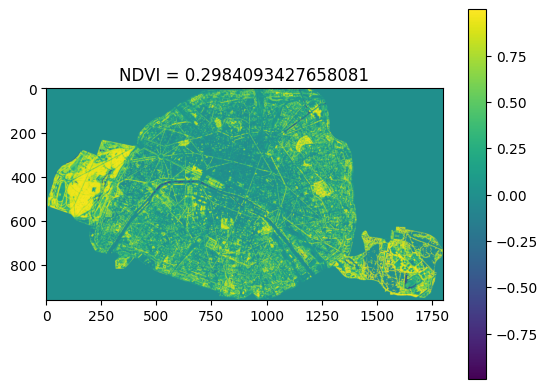

In [15]:
def compute_NDVI(individual_bands):
    nir = individual_bands["B8"].astype('float32')
    red = individual_bands["B4"].astype('float32')

    valid_mask = (nir != 0) & (red != 0) & ((nir + red) != 0)
    ndvi_map = np.zeros_like(nir)
    ndvi_map[valid_mask] = (nir[valid_mask] - red[valid_mask]) / (nir[valid_mask] + red[valid_mask])
    ndvi_val = np.mean(ndvi_map[valid_mask])

    return ndvi_val, ndvi_map

val, ndvi_map = compute_NDVI(individual_bands[0])
plt.imshow(ndvi_map)
plt.colorbar()
plt.title(f"NDVI = {val}")

<Figure size 640x480 with 0 Axes>

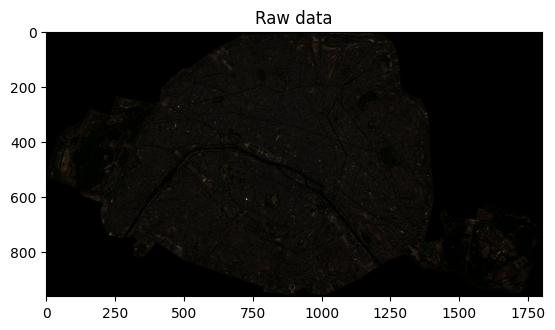

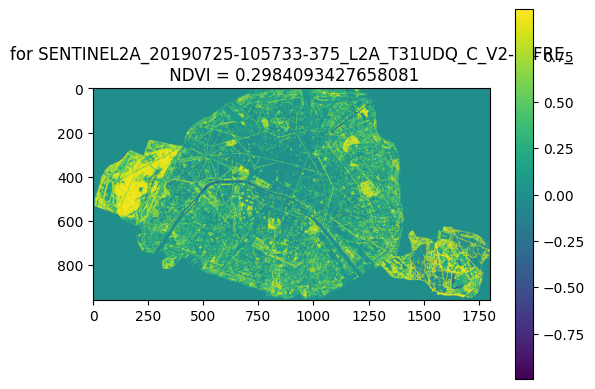

<Figure size 640x480 with 0 Axes>

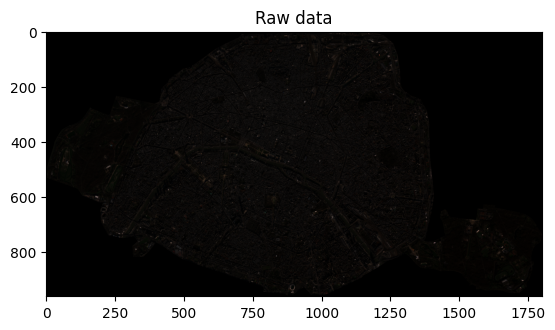

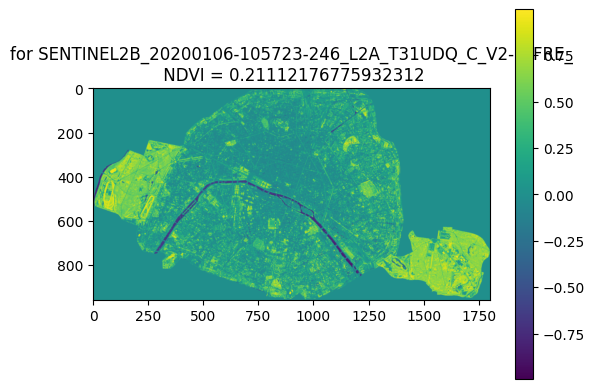

<Figure size 640x480 with 0 Axes>

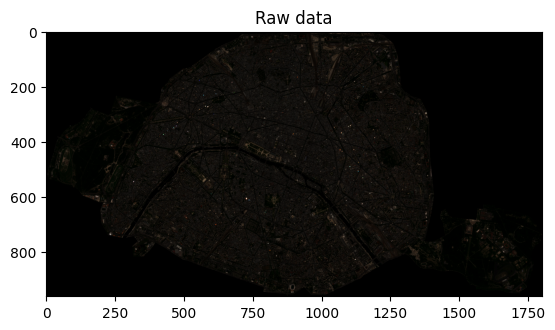

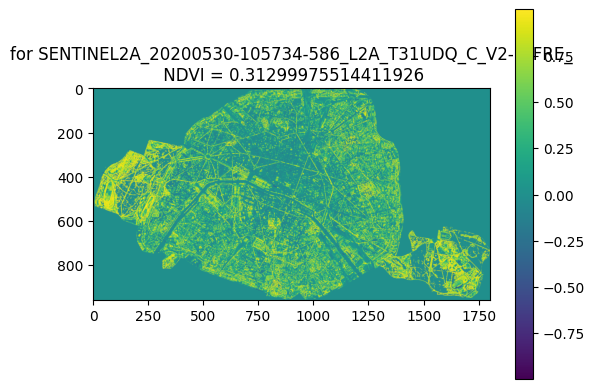

<Figure size 640x480 with 0 Axes>

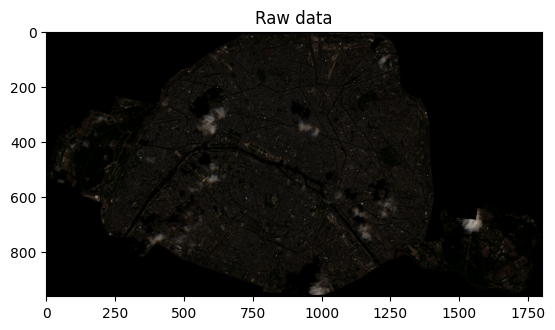

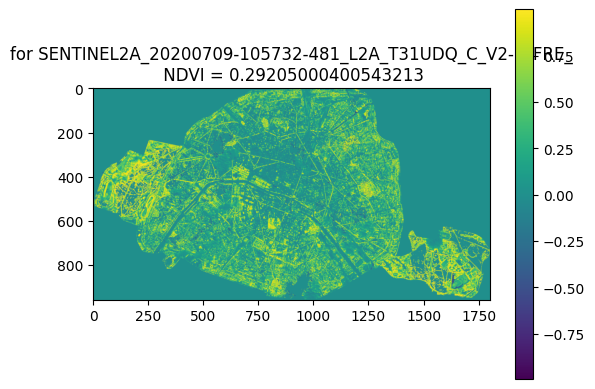

<Figure size 640x480 with 0 Axes>

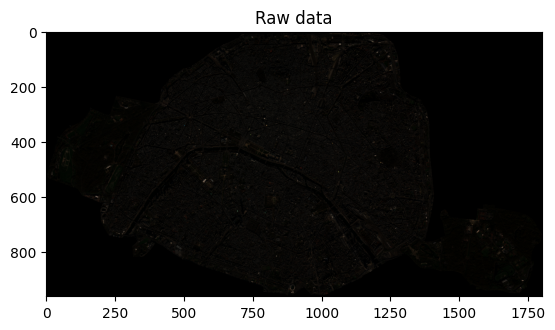

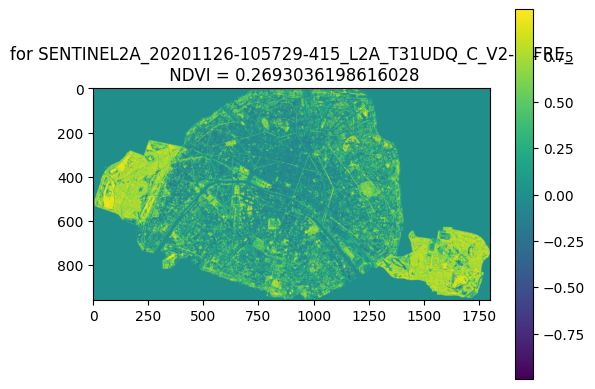

<Figure size 640x480 with 0 Axes>

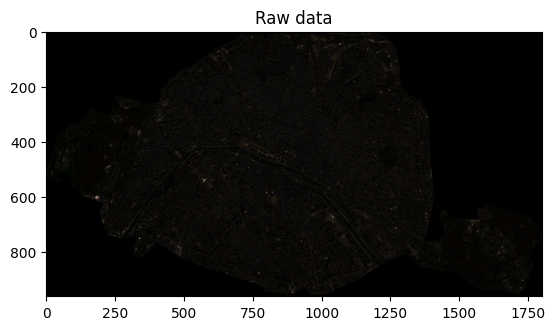

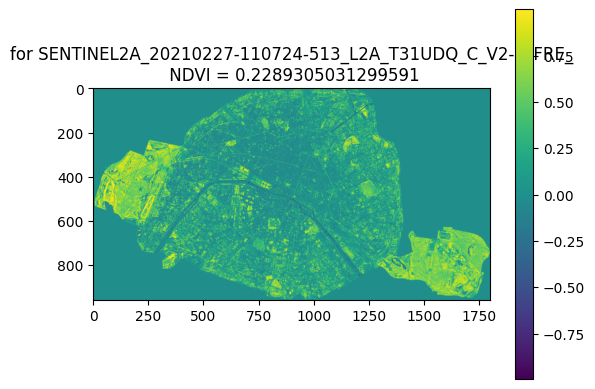

<Figure size 640x480 with 0 Axes>

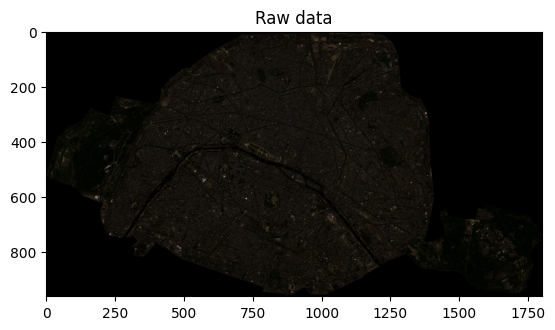

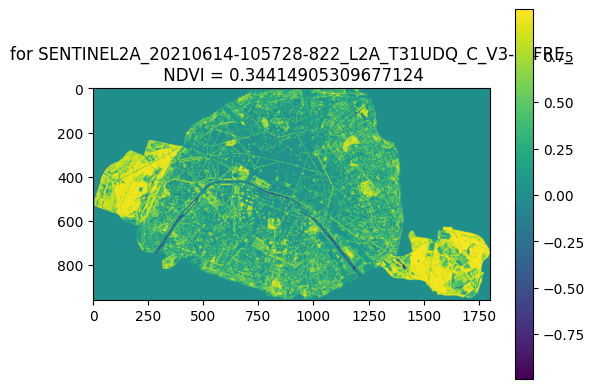

<Figure size 640x480 with 0 Axes>

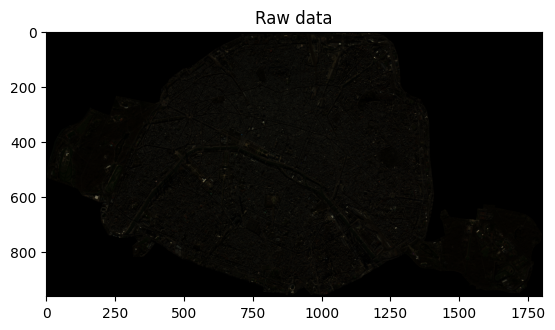

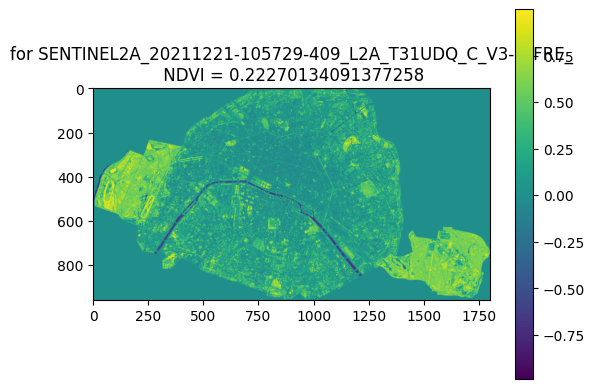

<Figure size 640x480 with 0 Axes>

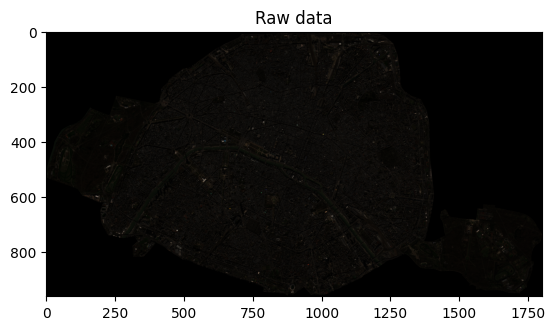

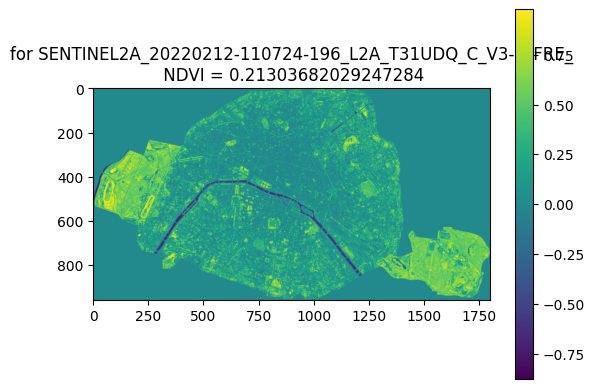

<Figure size 640x480 with 0 Axes>

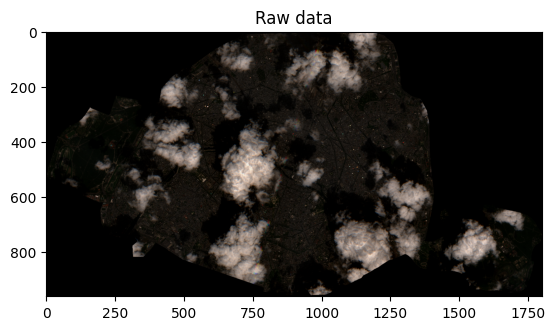

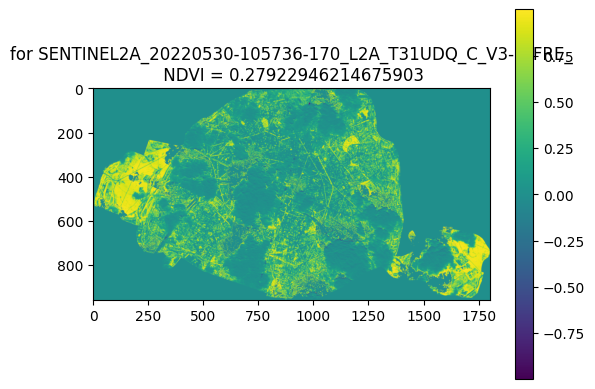

<Figure size 640x480 with 0 Axes>

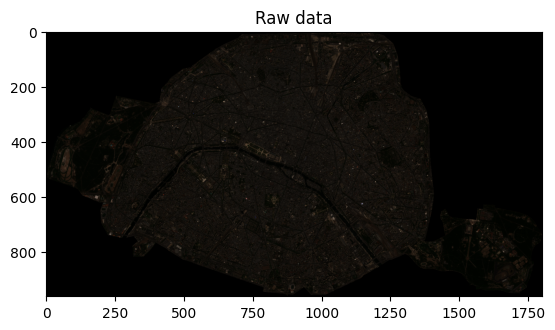

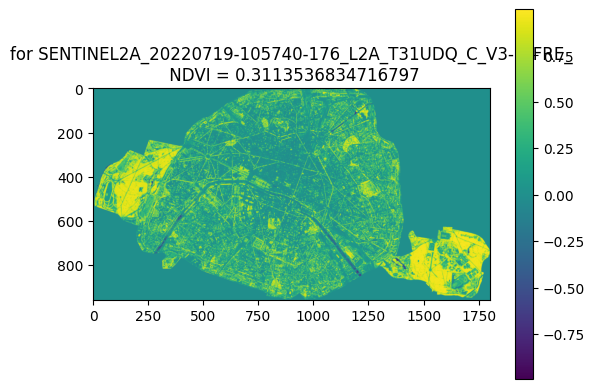

<Figure size 640x480 with 0 Axes>

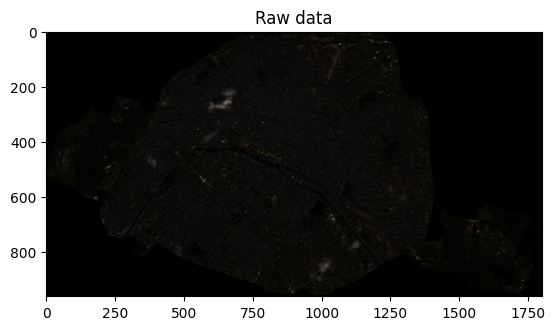

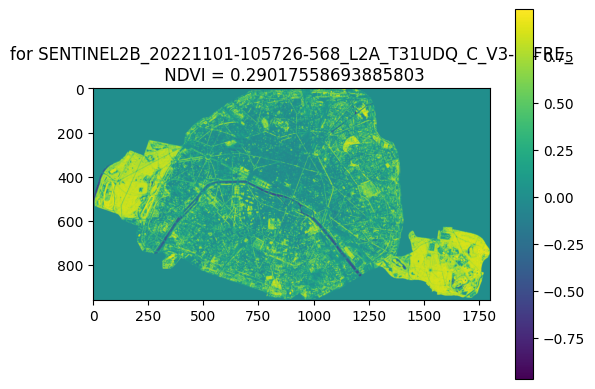

<Figure size 640x480 with 0 Axes>

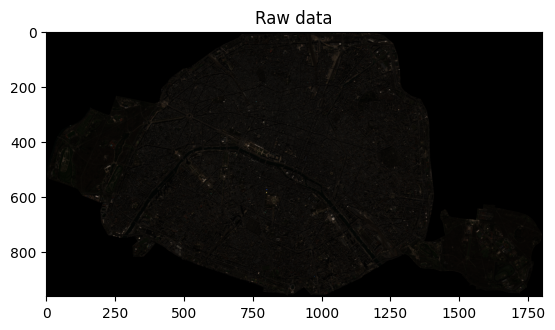

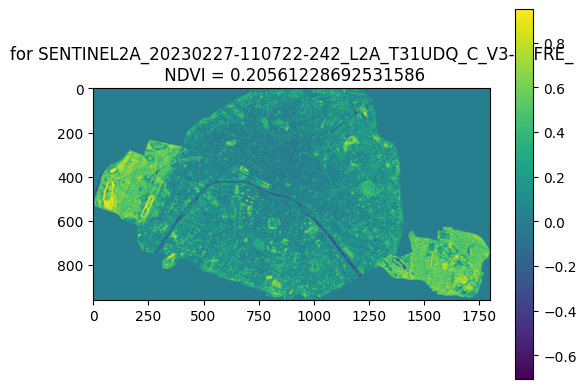

<Figure size 640x480 with 0 Axes>

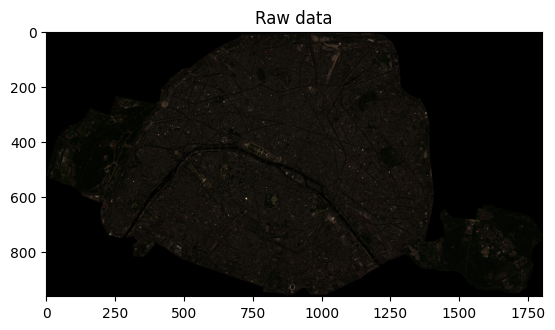

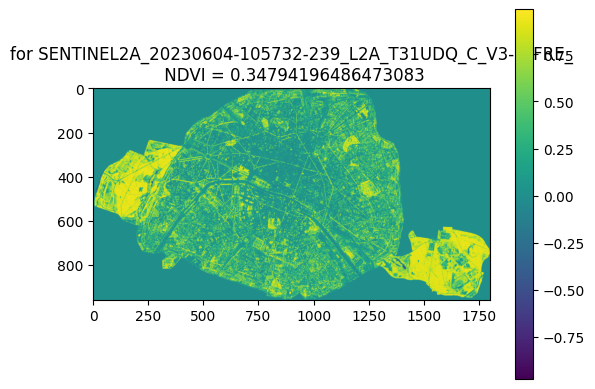

In [16]:
ndvi_vals = []

for index, filename in enumerate(filenames):
    val, ndvi_map = compute_NDVI(individual_bands[index])
    ndvi_vals.append(val)
    plt.figure()
    show_imageRGB(individual_bands[index], bands_to_print)
    plt.figure()
    plt.imshow(ndvi_map)
    plt.colorbar()
    plt.title(f"for {filename.split("/")[-1]}\n NDVI = {val}")

In [17]:
print(f"{ndvi_vals}")

[np.float32(0.29840934), np.float32(0.21112177), np.float32(0.31299976), np.float32(0.29205), np.float32(0.26930362), np.float32(0.2289305), np.float32(0.34414905), np.float32(0.22270134), np.float32(0.21303682), np.float32(0.27922946), np.float32(0.31135368), np.float32(0.2901756), np.float32(0.20561229), np.float32(0.34794196)]


**Question 3**
- After looking at the NDVI maps (you can also look at the original images), what are your thoughts? Can you use all of the images?
- Present and discuss the evolution of the NDVI in your report

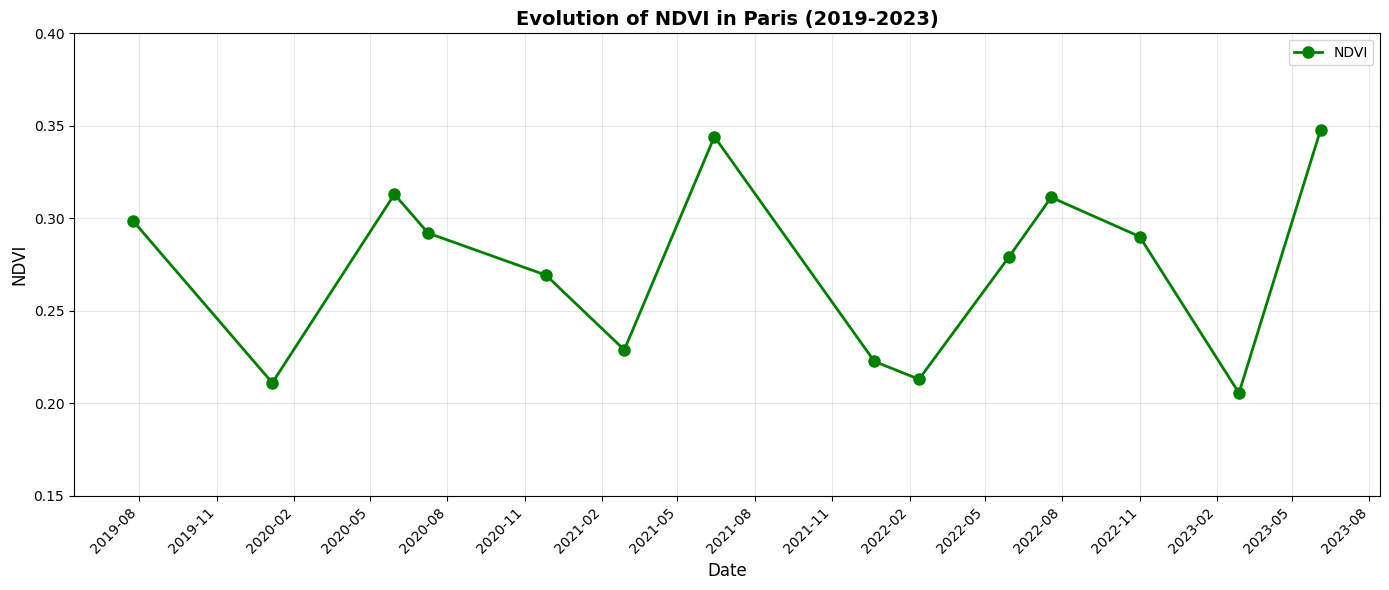

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Convert date strings to datetime objects
dates_dt = [datetime.strptime(date, '%Y%m%d') for date in dates]

# Create the plot
plt.figure(figsize=(14, 6))
plt.plot(dates_dt, ndvi_vals, 'o-', linewidth=2, markersize=8, color='green', label='NDVI')
plt.xlabel('Date', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.title('Evolution of NDVI in Paris (2019-2023)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0.15, 0.40)

# Format x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.legend()
plt.show()